In [ ]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import networkx as nx

from scipy.special import factorial, binom
from numpy.random import randint
from time import sleep
import imageio
import os

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

# Оценка на пересечение с большой вероятностью

В отчёте мы оценили размер пересечения через матожидание, и отсюда получили оценку снизу на k. Тем не менее при большой дисперсии некоторые пары пользователей могут пересекаться по малому числу файлов; а значит их подключение будет небезопасным.

Можно найти иную оценку на k: возьмём такое k, что с большой вероятностью $1-\delta$ размер пересечения будет не меньше $l$. Для этого выпишем формулу вероятности, что пользователи пересекаются ровно по $t$ файлам:

$$
P(|A_i \cap A_j| = t) = \frac{\binom{M-k}{k-t}\binom{k}{t}}{\binom{M}{k}}
$$

Отсюда получаем оценку:

$$
    P(|A_i \cap A_j| < \ell) = \sum_{t = 0}^{\ell-1}\frac{\binom{M-t}{k-t}\binom{k}{t}}{\binom{M}{k}} \le \delta
$$

Вывести аналитически формулу для такого $k$ не получится, но можно

In [ ]:
def calc_k(alpha, l, q, N, mean_estimate=True, delta=None, M=None):
    if M is None:
        M = ceil(l / (1 - (1 - alpha**(1/l))**(1/q))**2)
    if mean_estimate:
        return np.ceil(np.sqrt(M*l))

    for k in range(1, M+1):
        t_arr = np.arange(min(k, l), dtype=int)
        prob_arr = (binom(M-k, k-t_arr) / binom(M, k)) * binom(k, t_arr)
        # print(prob_arr.sum())
        if prob_arr.sum() <= delta:
            return k
    # for some l that may be impossible
    return -1

In [ ]:
N = 100
q = N * 0.02
alpha = 0.01
delta = 0.001

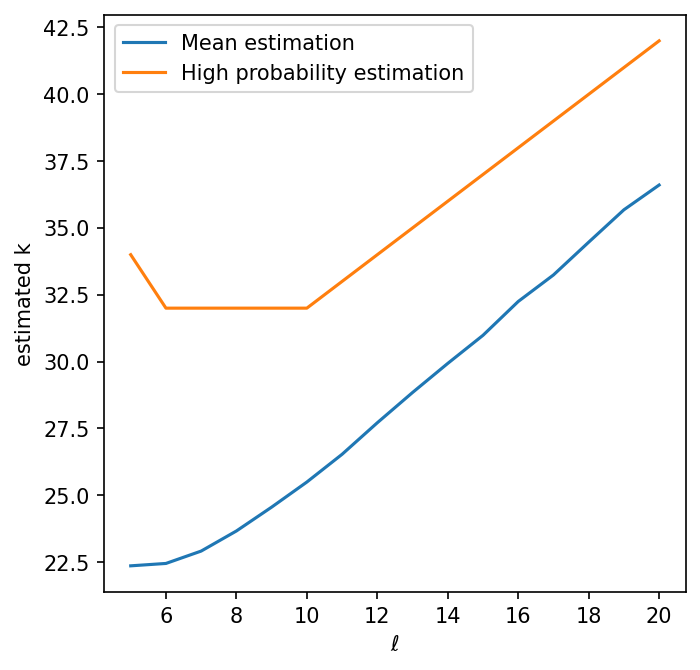

In [ ]:
mean_est = []
high_prob_est = []

l_range = np.linspace(5,20,16, dtype=int)

for l in l_range:
    mean_est.append(calc_k(alpha, l, q, N, True))
    high_prob_est.append(calc_k(alpha, l, q, N, False, delta))

plt.figure(figsize=(5,5))
plt.plot(l_range, mean_est, label="Mean estimation")
plt.plot(l_range, high_prob_est, label="High probability estimation")
plt.xlabel(r"$\ell$")
plt.ylabel("estimated k")
plt.legend();

В целом наблюдаем ошибку на константу, это не меняет фундаментальные теоретические выводы.

# Симуляция распространения файлов

## Реализация симуляции

Следующие параметры определяют нашу систему:

In [ ]:
N = 20         # total number of people
beta = 0.05    # proportion of Moriarties
alpha = 0.001  # acceptable risk
l = 4          # number of common files required for safe communication
delta = 0.001  # acceptable error of k estimation

# G: connectivity graph. We'll generate random d-regular:
d = (N-1) // 3
G = nx.random_regular_graph(d, N)

Остальные вычисляются через них:

In [ ]:
q = ceil(N * beta)                                  # number of Moriarties
x = ceil(l/N / (1 - (1 - alpha**(1/l))**(1/q))**2)  # number of files generated per person
M = N * x                                           # total number of files
k = calc_k(alpha, l, q, N, False, delta, M)         # number of files that each person should know
print(f"M={M}, k={k}, x={x}")

M=140, k=38, x=7


Визуализируем матрицу связности графа:

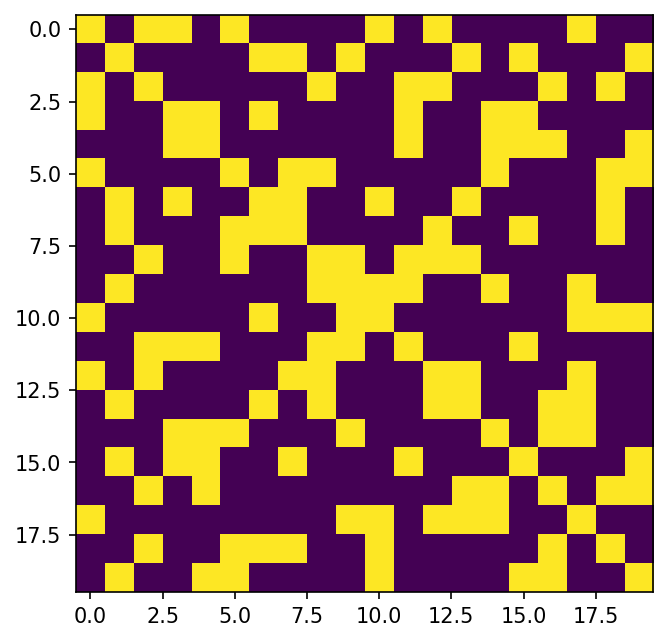

In [ ]:
connectivity = np.eye(N)
for i, j in G.edges:
    connectivity[i-1][j-1] = 1
    connectivity[j-1][i-1] = 1
plt.figure(figsize=(5,5))
plt.imshow(connectivity);

Для распространения используем следующие массивы:
* `edges: list[list]` - рёбра в графе связности (файлы можно передавать только по этим рёбрам).
* `held_files: list[list]` - список кортежей (*номер_флешки*, *количество_оставшихся_записей*) для каждого пользователя.
* `known_files: np.ndarray[N][M]` - булева матрица файлов, которые скопировал себе каждый из пользователей.

Т.к. все распределения равномерны по пользователям, будем считать что последние q пользователей - Мориарти.

In [ ]:
def generate_arrays(G, x, k):
    N = len(G)
    M = N * x
    edges = [[] for _ in range(N)]
    for i, j in G.edges:
        edges[i].append(j)
        edges[j].append(i)

    # person 0: 0 ... x-1, person 1: x ... 2x-1 and so on
    held_files = [[i*x + j for j in range(x)] for i in range(N)]

    # initialize known_files from held_files
    known_files = np.zeros((N, M), dtype=bool)
    known_files[np.repeat(np.arange(N), x), np.array(held_files).reshape(-1)] = 1

    # add remaining transfers to held_files:
    n_transfers = ceil(k/x) - 1
    held_files =  [[(i*x + j, n_transfers) for j in range(x)] for i in range(N)]

    return edges, held_files, known_files

In [ ]:
def rand_propagate(edges: list[list], held_files: list[list], known_files: np.ndarray):
    """
    Random file propagation: each person shares 1 (if possible) file with one of the neighbors
    """
    N, M = known_files.shape

    n_empty = 0
    for i in range(N):
        # choose file to transfer
        if len(held_files[i]) == 0:
            n_empty += 1
            continue
        file_id, remaining_transfers = held_files[i].pop(randint(len(held_files[i])))
        # give to random neighbor
        j = np.random.choice(edges[i])
        known_files[j][file_id] = 1
        # flash drive is destroyed after k/x uses
        if remaining_transfers > 0:
            held_files[i].append((file_id, remaining_transfers-1))
    
    return n_empty

За визуализацию симуляции будет отвечать отдельный класс. Если ему в качестве параметра передан граф, то мы также будем визуализировать появление общих файлов всех пользователем с первым.

In [ ]:
class Vizualizer:
    def __init__(self, G=None, l=None, save_frames=False, params={}):
        """
            Args:
                G: networkx.graph - if specified graph will be vizualized
                l: Optional[int] - l parameter (needed for G vizualization)
                save_frames: bool - if True, each drawn frame will be saved to self.frames buffer
                params: dict - experiment params to print
        """
        self.G = G
        self.l = l
        self.save_frames = save_frames
        self.frames = []
        self.params = params
    
        if G is None:
            self.fig, self.axs = plt.subplots(figsize=(12, 6), ncols=2)
        else:
            self.fig, self.axs = plt.subplots(figsize=(18, 6), ncols=3)
            self.pos = nx.spring_layout(G)

        self.cbars = [
            self.fig.colorbar(plt.cm.ScalarMappable(), ax=self.axs[0], fraction=0.046, pad=0.04),
            self.fig.colorbar(plt.cm.ScalarMappable(), ax=self.axs[1], fraction=0.046, pad=0.04),
        ]
        self.step = 0


    def calculate_file_stats(self, known_files: np.ndarray):
        """
            Calculates stats to be visialized using known_files matrix
            Args:
                known_files: np.ndarray[N, M] - bool matrix of files known by each user
        """
        N, M = known_files.shape
        self.pairs = N * (N-1) // 2

        common_files = known_files.reshape(N, 1, M) & known_files.reshape(1, N, M) # N x N x M
        n_common = common_files.sum(axis=-1) # N x N, number of common files

        moriarty_files = np.any(known_files[-q:], axis=0)
        hackable_files = (common_files & moriarty_files.reshape(1,1,M)).sum(axis=-1)

        # danger - NxN matrix of proportion of shared files known to Moriarty
        # 0 if user pair doesn't have a connection, and for the same user
        danger = np.zeros((N,N))
        np.divide(hackable_files, n_common, where=n_common!=0, out=danger)
        np.fill_diagonal(danger, 0)
        # moriarty doesn't hack himself
        danger[-q:] = 0
        danger[:,-q] = 0

        self.n_common = n_common
        self.danger = danger
        self.hacked = danger==1


    def vizualize(self, known_files):
        self.calculate_file_stats(known_files)
        not_connected_pairs = np.sum(self.n_common==0) // 2
        np.fill_diagonal(self.n_common, 0)

        clear_output(wait=True)
        plt0 = self.axs[0].imshow(self.n_common, cmap="hot")
        self.axs[0].set(title="Number of Shared Files for each User Pair")
        plt1 = self.axs[1].imshow(self.danger, cmap="hot")
        self.axs[1].set(title="Proportion of Shared Files Known by Moriarties")
        self.cbars[0].update_normal(plt0)
        self.cbars[1].update_normal(plt1)

        s1 = ', '.join(f"{key}={val}" for (key,val) in self.params.items())
        s2 = f"Not Connected Pairs: {not_connected_pairs} / {self.pairs}"
        s3 = f"Pairs Hacked by Moriarties: {np.sum(self.hacked)//2} / {self.pairs}"
        self.fig.suptitle("\n".join([s1,s2,s3]), fontsize=14)

        self.vizualize_graph()
        display(plt.gcf())
        self.save_frame()
        self.step += 1

    
    def vizualize_graph(self):
        if self.G is None or self.l is None:
            return

        green = np.array([0,1,0]).reshape(1,3)
        N = self.n_common.shape[0]
        cmap = np.zeros((N, 3))
        # 0 common files <=> black
        # at least l common files <=> green
        green_coef = np.clip(self.n_common[0].reshape(-1, 1) / l, 0, 1)
        cmap += green_coef * green
        cmap[0] = np.array([0,0,1])
        nx.draw(self.G, pos=self.pos, ax=self.axs[2], node_color=cmap)


    def save_frame(self):
        if not self.save_frames:
            return

        plt.savefig("tmp.png", transparent = False, facecolor = "white")
        img = imageio.v2.imread("tmp.png")
        self.frames.append(img)
        os.remove("tmp.png")


    def build_gif(self, filename):
        if not self.save_frames:
            return

        imageio.mimsave(filename, self.frames, fps=5)

In [ ]:
def run_simulation(G, x, k, q, l=None, draw_freq=1, draw_graph=False, filename=None, params={}):
    n_empty = 0
    N = len(G)

    save_frames = filename is not None
    arg_G = None if not draw_graph else G
    vizualizer = Vizualizer(G=arg_G, l=l, save_frames=save_frames, params=params)
    
    edges, held_files, known_files = generate_arrays(G, x, k)
    n_iter = 0

    while n_empty != N:
        n_empty = rand_propagate(edges, held_files, known_files)
        if n_iter % draw_freq == 0:
            vizualizer.vizualize(known_files)
        n_iter += 0

    vizualizer.build_gif(filename)
    plt.close(vizualizer.fig)
    return known_files

Соберём весь эксперимент в 1 функцию, которая принимает параметры задающую систему:

In [ ]:
def run_exp(N, beta, alpha, l, delta=0.01, d_coef=1, x_mult=1, mean_estimate=True, draw_graph=False, filename=None):
    """
        Run simulation experiment
        Args:
            N: int - number of users,
            beta: float - percent of Moriarties (q = N*b)
            alpha: float - allowable probability of being hacked
            delta: float - probability <<1 for high-probability k estimation
            d_coef: float - coefficient of graph connectivity (each node has degree = (N-1) * d_coef)
            x_mult: float - x and k multiplier (k needs to be multiplied to keep the same amount of transfers)
            mean_estimate: bool - whether or not estimate k via mean
            draw_graph: bool - whether or not to vizualize graph and first vertex connections in it
                               first vertex is drawn as blue,
                               the rest become greener as they get more shared filed with the first one
            filename: Optional[string] - filename to save gif 

    """
    d = ceil((N-1) * d_coef)
    G = nx.random_regular_graph(d, N)
    q = ceil(N * beta)
    x = ceil(l / N / (1 - (1 - alpha**(1/l))**(1/q))**2)
    M = N * x
    x *= x_mult
    k = calc_k(alpha, l, q, N, mean_estimate, delta, M)
    k *= x_mult
    params = {
        "N" : N,
        "q" : q,
        "alpha" : alpha,
        "l" : l,
        "x" : x,
        "k" : k,
        "d" : d,
    }

    kn = run_simulation(G, x, k, q, l, draw_graph=draw_graph, filename=filename, params=params);

## Эксперименты

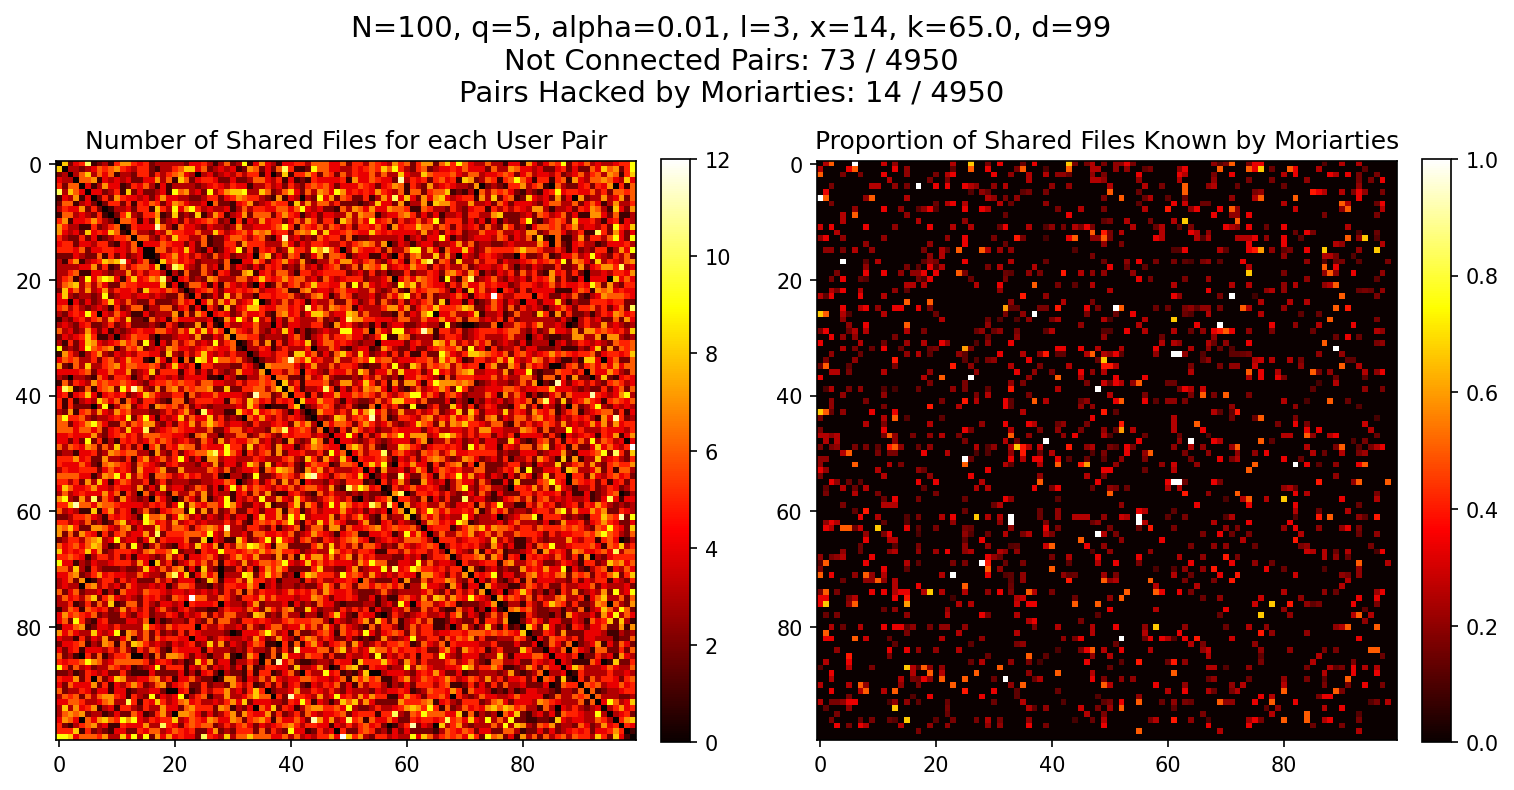

In [ ]:
# this may take some time (due to a lot of plotting)
run_exp(100, 0.05, 0.01, 3, filename="fully_connected.gif")

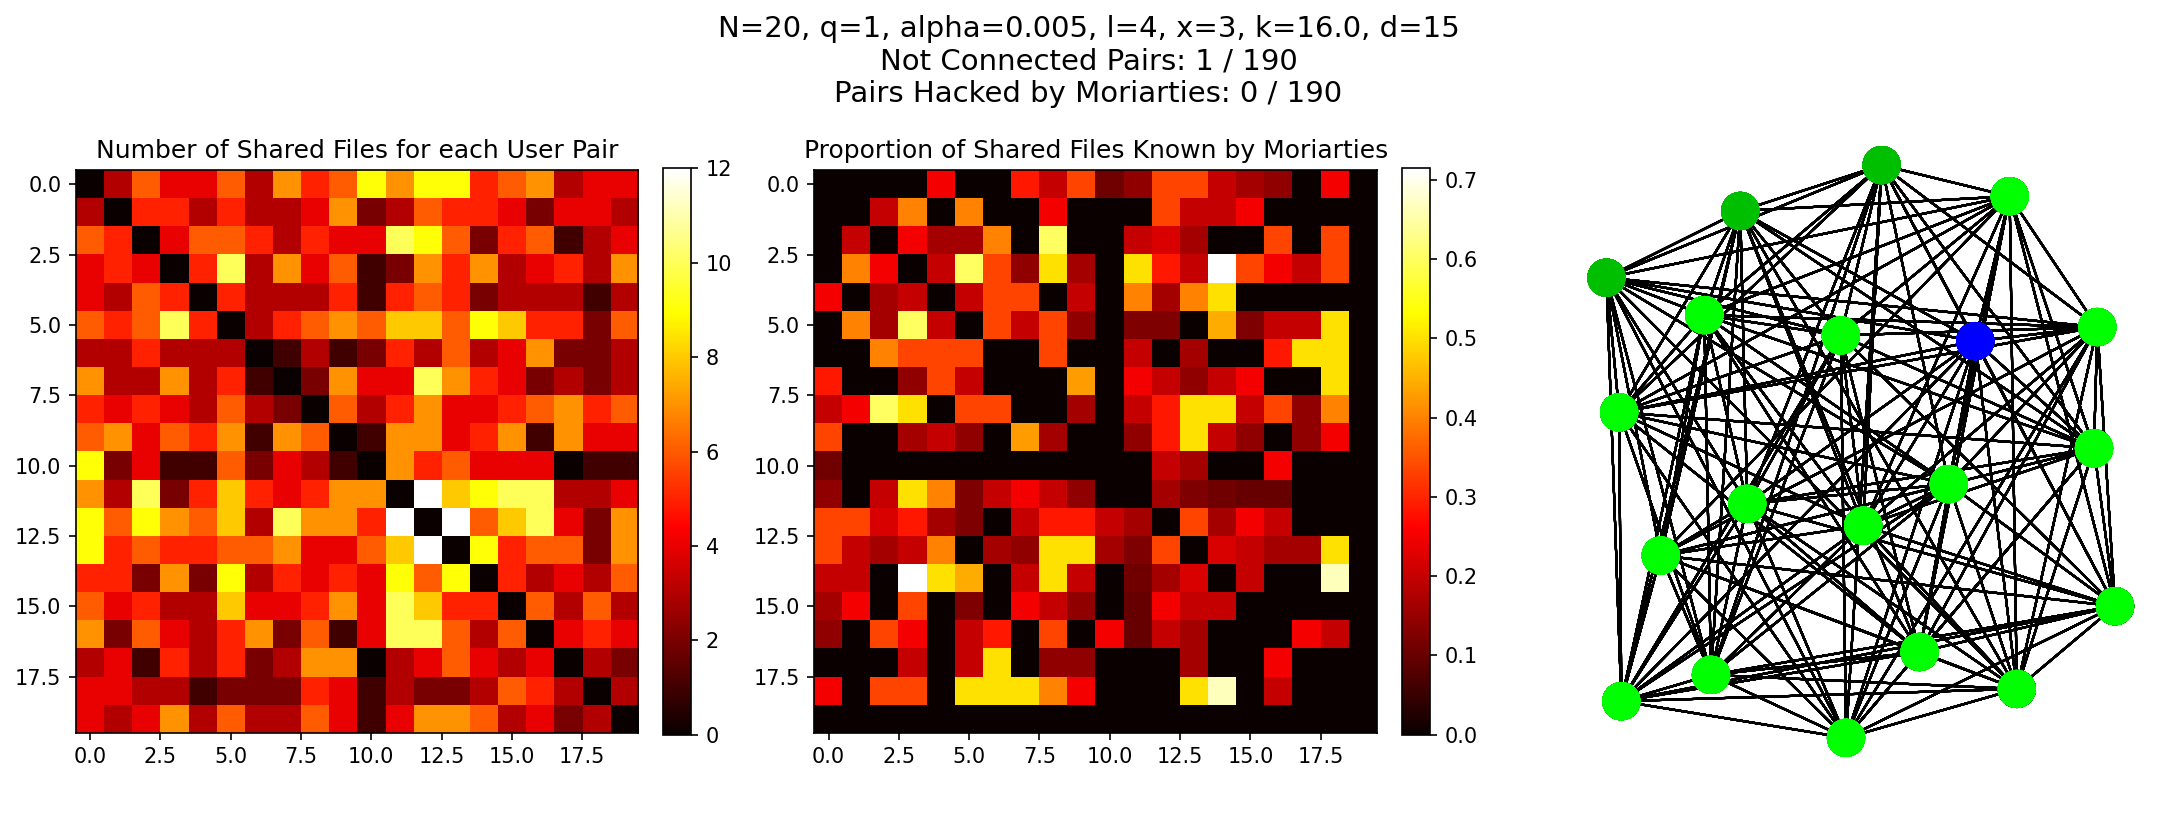

In [ ]:
run_exp(20, 0.05, 0.005, 4, d_coef=0.75, draw_graph=True, filename="highly_connected.gif")

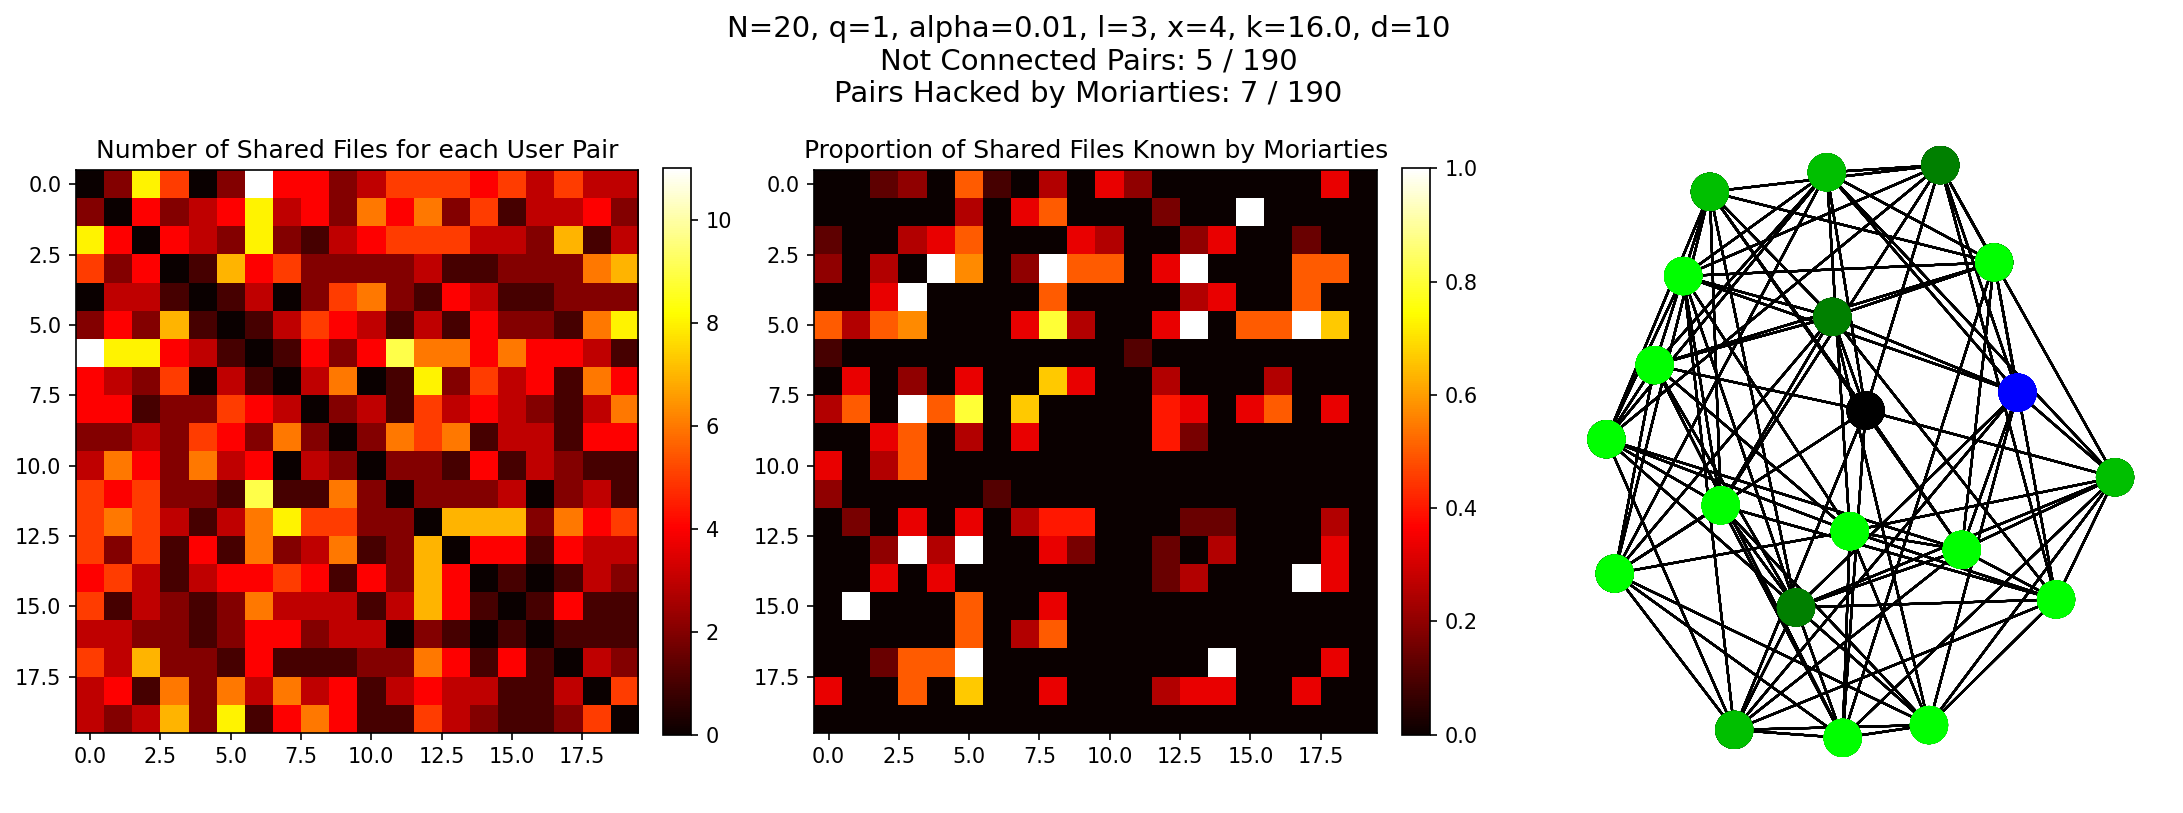

In [ ]:
run_exp(20, 0.05, 0.01, 3, d_coef=0.5, draw_graph=True, filename="medium_connected.gif")

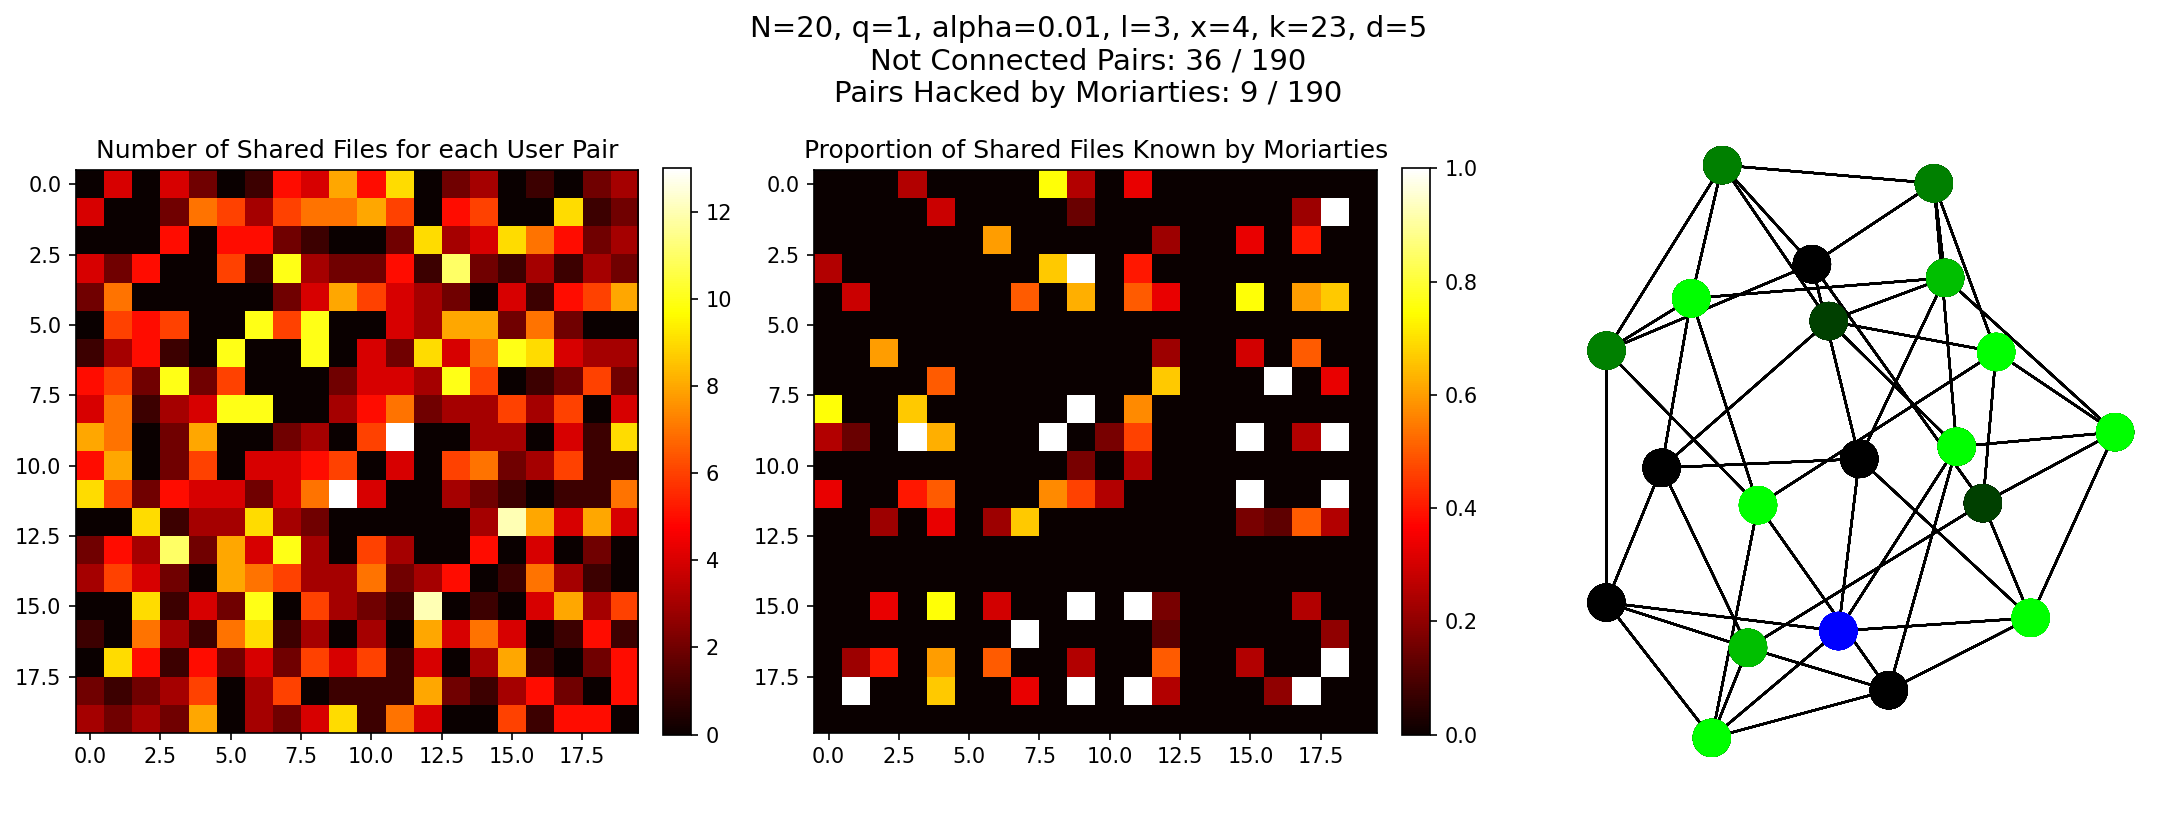

In [ ]:
run_exp(20, 0.05, 0.01, 3, d_coef=0.25, draw_graph=True, filename="weakly_connected.gif", mean_estimate=False)

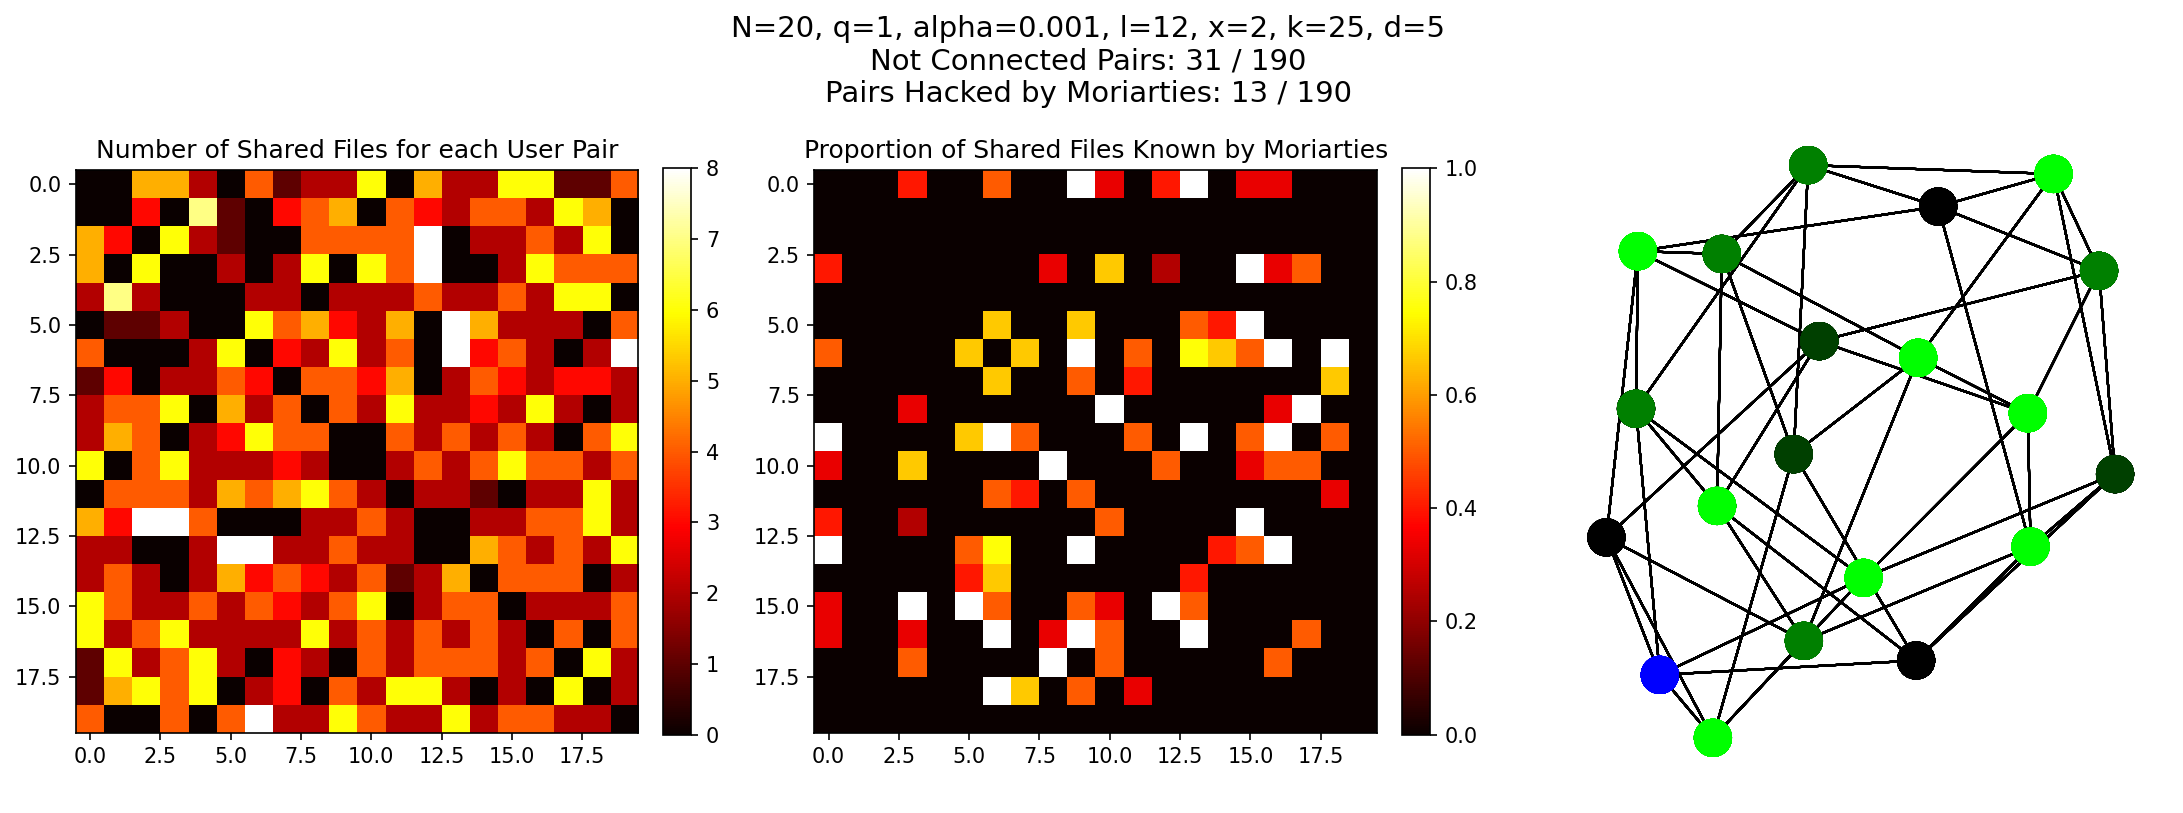

In [ ]:
run_exp(20, 0.05, 0.001, 12, d_coef=0.25, draw_graph=True, filename="weakly_connected_impoved.gif", mean_estimate=False)

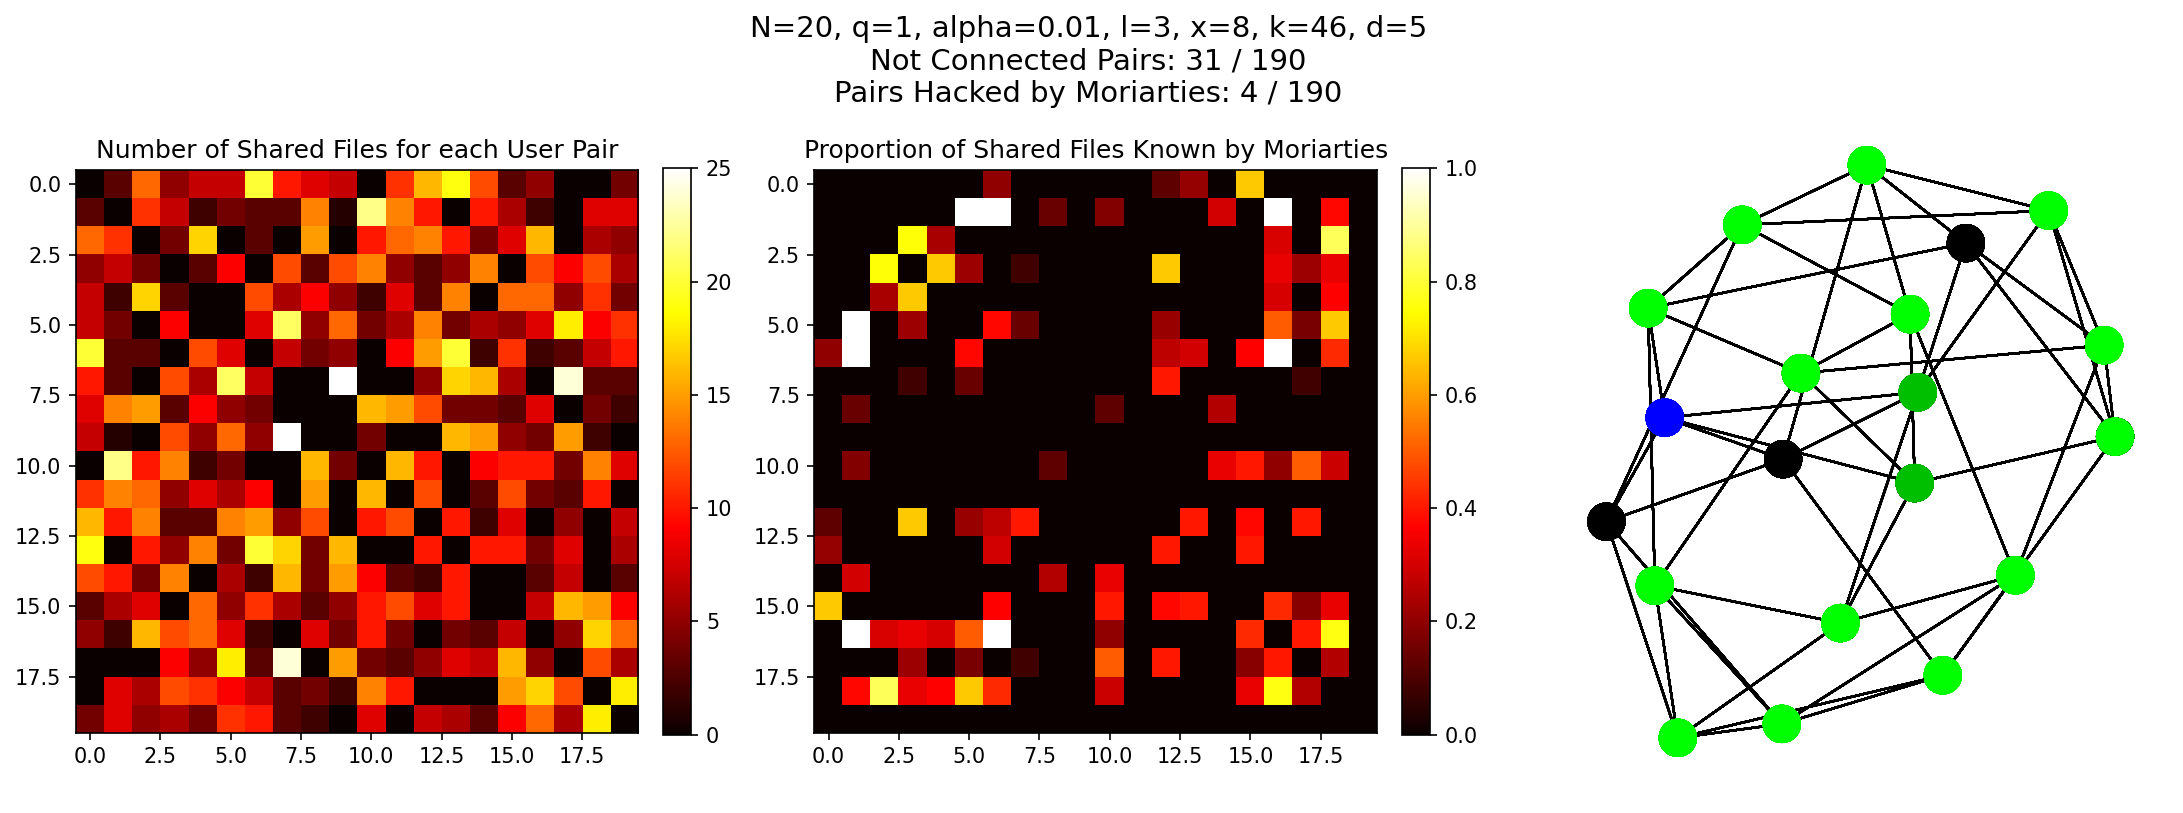

In [ ]:
run_exp(20, 0.05, 0.01, 3, d_coef=0.25, draw_graph=True, x_mult=2, filename="weakly_connected.gif", mean_estimate=False)